# Lab 4: Mindspore实现手写数字识别

## Before we start

我们创建了[实验课的github仓库](https://github.com/Yujie-G/ML-2024Spring)，你可以在这里找到所有的实验指导书和相关资源。

由于众所周知的原因，我们会在智慧树平台上上传一份实验资源的拷贝，不使用git仓库**不会**影响你完成实验。

为什么使用git?

1. 你可以第一时间获取实验指导代码的更新，代码框架的修改等。
2. 你可以方便的在本地查看代码的变更和历史。
3. 你可以在issue中提出关于实验代码的问题，可以帮助到有相同问题的同学。


How to start:

初始化：
```bash
git clone git@github.com:Yujie-G/ML-2024Spring.git
```

之后，每次新实验发布，你可以通过以下命令来更新本地仓库：
```bash
git pull
```


## TODO

1. 安装Mindspore
2. 阅读并理解全连接网络的实现代码
3. 实现LeNet5网络(部分代码已给出)

## 1. 安装Mindspore

[进入官网获取下载命令](https://www.mindspore.cn/install)， 建议选择2.1.1版本的Mindspore, 安装方式选择pip/conda安装均可

不会Mindspore?可以点击[这里](https://www.mindspore.cn/tutorials/zh-CN/r2.2/index.html)学习官方教程

你也可以参考[官方的API文档](https://www.mindspore.cn/docs/zh-CN/r2.1/index.html)

## 2. 利用Mindspore实现全连接网络手写数字识别

你可以参考[这份华为官方的指导手册](./assets/MindsporeTutorial.pdf),查看Mindspore的教程

In [1]:
import mindspore
from mindspore import ops
from mindspore import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 加载MNIST数据集
train_dataset_dir = "./MNIST/train"
train_dataset = MnistDataset(dataset_dir=train_dataset_dir)
test_dataset_dir = "./MNIST/test"
test_dataset = MnistDataset(dataset_dir=test_dataset_dir)

print(train_dataset.get_col_names())

['image', 'label']


In [4]:
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = datapipe(train_dataset, 64)
test_dataset = datapipe(test_dataset, 64)

In [5]:
for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


In [6]:
for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


In [7]:
# 网络构建
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )
    
    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits
    
model = Network()
print(model)

Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >


In [8]:
# 模型训练
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

In [9]:
def train(model, dataset, loss_fn, optimizer):
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits
    
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)
    
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss
    
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        
        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

In [10]:
def test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, train_dataset, loss_fn, optimizer)
    test(model, test_dataset, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.055614  [  0/938]
loss: 0.074898  [100/938]
loss: 0.090094  [200/938]
loss: 0.073458  [300/938]
loss: 0.036597  [400/938]
loss: 0.113472  [500/938]
loss: 0.090123  [600/938]
loss: 0.112469  [700/938]
loss: 0.081419  [800/938]
loss: 0.035383  [900/938]
Test: 
 Accuracy: 96.9%, Avg loss: 0.099123 

Epoch 2
-------------------------------
loss: 0.177960  [  0/938]
loss: 0.140007  [100/938]
loss: 0.079025  [200/938]
loss: 0.087178  [300/938]
loss: 0.230235  [400/938]
loss: 0.110756  [500/938]
loss: 0.053181  [600/938]
loss: 0.084230  [700/938]
loss: 0.024468  [800/938]
loss: 0.062206  [900/938]
Test: 
 Accuracy: 97.1%, Avg loss: 0.091054 

Epoch 3
-------------------------------
loss: 0.062178  [  0/938]
loss: 0.052646  [100/938]
loss: 0.132047  [200/938]
loss: 0.173868  [300/938]
loss: 0.158869  [400/938]
loss: 0.075314  [500/938]
loss: 0.180499  [600/938]
loss: 0.065313  [700/938]
loss: 0.088117  [800/938]
loss: 0.060853  [900/938]
Test: 
 

In [13]:
# Save checkpoint
mindspore.save_checkpoint(model, "model.ckpt")
print("Saved Model to model.ckpt")

Saved Model to model.ckpt


In [14]:
# Instantiate a random initialized model
model = Network()
# Load checkpoint and load parameter to model
param_dict = mindspore.load_checkpoint("model.ckpt")
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load)

[]


In [15]:
model.set_train(False)
for data, label in test_dataset:
    pred = model(data)
    predicted = pred.argmax(1)
    print(f'Predicted: "{predicted[:10]}", Actual: "{label[:10]}"')
    break

Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >

Predicted: "[7 1 1 3 8 0 4 0 9 7]", Actual: "[7 1 1 3 8 0 4 0 9 7]"


## 3. 实现LeNet5网络

![](assets/images/2024-04-07-22-36-11.png)


根据上图说明的参数，实现LeNet5网络，完成手写数字识别任务，部分代码已给出，你需要补全代码

你可能会用到的[MindSpore卷积神经网络API](https://www.mindspore.cn/docs/zh-CN/r2.1/api_python/mindspore.nn.html#%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B1%82)

In [1]:
# import necessary pkgs
import os
import numpy as np
import mindspore as ms
import mindspore.nn as nn
from mindspore import Model
import mindspore.dataset as ds



In [2]:
# !设置全局种子，这里改成你的学号后四位
np.random.seed(777)
ms.set_seed(777)


## hyperparameters
batch_size = 32
epoch_size = 10
learning_rate = 0.01

dataset_dir = "./MNIST"


In [14]:
# 导入你需要的包
## pkgs import
import mindspore.dataset as ds
import mindspore.dataset.vision as CV
import mindspore.dataset.transforms as C
from mindspore import dtype as mstype

resize_height, resize_width = 32, 32
rescale = 1.0 / 255.0
shift = 0.0
rescale_nml = 1 / 0.3081
shift_nml = -1 * 0.1307 / 0.3081


def create_dataset(data_path, batch_size=32, repeat_size=1, num_parallel_workers=1):

    # 创建数据集
    mnist_ds = ds.MnistDataset(data_path)

    # 实现数据增强和处理(不要忘记处理label)
    # 1. 将图像缩放到模型需要的输入，比如32x32, 插值方式为线性插值。
    # [附加题] 将图像的对比度和亮度做适当的调整，调整幅度任意。 [提示：需要先对色彩空间进行转化]
    """
    ==========================修改这部分代码=======================
    """
    image_trans = [
        CV.Rescale(rescale_nml, shift_nml),
        CV.Rescale(rescale, shift),
        CV.HWC2CHW(),
    ]
    label_trans = C.TypeCast(mstype.int32)
    mnist_ds = mnist_ds.map(operations=image_trans,input_columns=["image"], num_parallel_workers=num_parallel_workers)
    """
    ===============================================================
    """

    # 当需要对**指定标签**的数据进行增强时，可以使用类似下面的双变量迭代方式, 例如：
    # mnist_ds = mnist_ds.map(operations=(lambda img, lb: ... if lb == ... else ...),input_columns=["image", "label"], num_parallel_workers=num_parallel_workers)
    # 处理生成的数据集
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds


train_dataset = create_dataset(os.path.join(dataset_dir, "train"), batch_size=batch_size)
test_dataset = create_dataset(os.path.join(dataset_dir, "test"), batch_size=batch_size)

In [15]:
# this part is for debug use
image, label = next(train_dataset.create_tuple_iterator())
print(train_dataset.get_dataset_size())
print(image.shape, image.dtype, f", the result should be ({batch_size}, 1, {resize_height}, {resize_width}) Float32")
print(label.shape, label.dtype, f", the result should be ({batch_size},) Int32")

1875
(32, 1, 32, 32) Float32 , the result should be (32, 1, 32, 32) Float32
(32,) Int32 , the result should be (32,) Int32


In [ ]:
class LeNet5(nn.Cell):
    '''
    code here
    '''


In [ ]:
net = LeNet5()
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optim = nn.Momentum(params=net.trainable_params(), learning_rate=learning_rate, momentum=0.9)
model = Model(network = net, loss_fn=loss, optimizer=optim, metrics={"Accuracy": nn.Accuracy()})

#### 训练遇到报错？先在[Q&A](https://github.com/Yujie-G/ML-2024Spring/tree/main/Q%26A)中看看有没类似情况

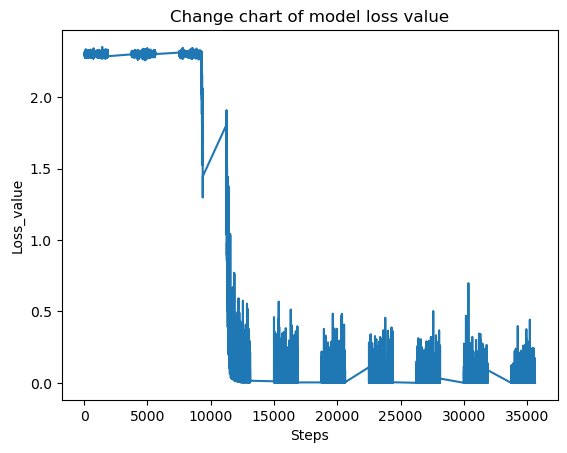

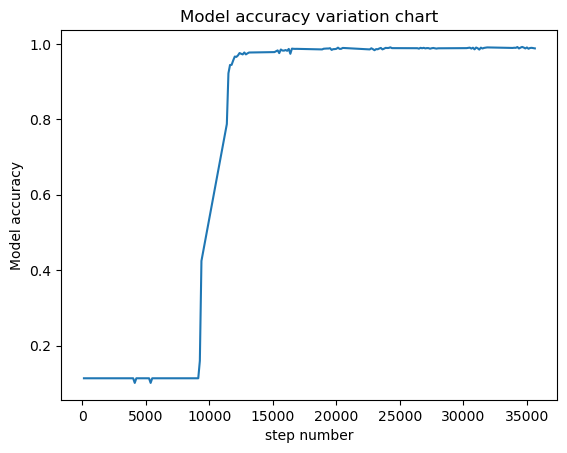

In [ ]:
# 实现训练部分代码，并打印训练过程中的loss值，[建议]可视化查看loss值的变化

"""
code here
"""


In [ ]:
## test
def test_net(network, model, path):
    """Define the evaluation method."""
    # 加载已保存的模型
    param_dict = ms.load_checkpoint(path)
    # load parameter to the network
    ms.load_param_into_net(network, param_dict)
    # evaluation
    acc = model.eval(test_dataset, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

# 修改为你的checkpoint路径
test_net(net, model, "/path/to/your/ckpt")

============== Accuracy:{'Accuracy': 0.9878806089743589} ==============
